### Train the model

In [1]:
import os
os.chdir("/Users/hxi/University/DL/DeepPhase4Audio")

In [ ]:
!./train.sh

### Test Reconstruction


##### Load the model and set it to eval mode

In [20]:
import pytorch_lightning as pl
import os

from src.experiments.pae_flattened import PAEInputFlattenedModel
from src.utils.config import load_config

cfg_path = "configs/baseline.yaml"
model_ckpt_path = "logs/checkpoints/epoch=13-step=126.ckpt"

cfg = load_config(cfg_path, flatten=True)
lightning_model = PAEInputFlattenedModel.load_from_checkpoint(model_ckpt_path, cfg=cfg)
model = lightning_model.model

print(model)

Number of samples in train split: 155
Number of samples in valid split: 19
Number of samples in test split: 20
Custom logic when loading checkpoint
PAEInputFlattened(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=same)
  (norm1): LN_v2()
  (conv2): Conv1d(16, 5, kernel_size=(7,), stride=(1,), padding=same)
  (fc): ModuleList(
    (0-4): 5 x Linear(in_features=32000, out_features=2, bias=True)
  )
  (deconv1): Conv1d(5, 16, kernel_size=(7,), stride=(1,), padding=same)
  (denorm1): LN_v2()
  (deconv2): Conv1d(16, 1, kernel_size=(7,), stride=(1,), padding=same)
)


/Users/hxi/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


##### Load data and test model

In [ ]:
from torch.utils.data import DataLoader

from src.datasets.data_processing import AudioDataset

model.eval()

# load dataset
D_test = AudioDataset(dataset_root='data', split='test')
D_train = AudioDataset(dataset_root='data', split='train')
x_train_sample = D_train[0]
x_test_sample = D_test[0]
print("test sample: ", x_test_sample)

# get model outputs
y, latent, signal, params = model(x_test_sample)

print("latent signal params (p, f, a, b): ", params)
print(f"orig signal shape: {x_test_sample.shape}, latent signal shape: {signal.shape}")


test sample:  tensor([[-0.1455, -0.2266, -0.2582,  ...,  0.4181,  0.4022,  0.3964]])
latent signal params (p, f, a, b):  [tensor([[[ 0.1955],
         [ 0.4119],
         [ 0.0587],
         [ 0.1633],
         [-0.0532]]], grad_fn=<UnsqueezeBackward0>), tensor([[[ 92.6276],
         [100.1289],
         [ 96.2236],
         [148.2986],
         [102.0164]]], grad_fn=<UnsqueezeBackward0>), tensor([[[2.0933],
         [1.7322],
         [2.1383],
         [1.2779],
         [2.3460]]], grad_fn=<UnsqueezeBackward0>), tensor([[[ 0.0482],
         [ 0.0266],
         [-0.0460],
         [ 0.0139],
         [-0.1013]]], grad_fn=<UnsqueezeBackward0>)]
orig signal shape: torch.Size([1, 32000]), latent signal shape: torch.Size([1, 5, 32000])


ValueError: x and y must have same first dimension, but have shapes (500,) and (32000,)

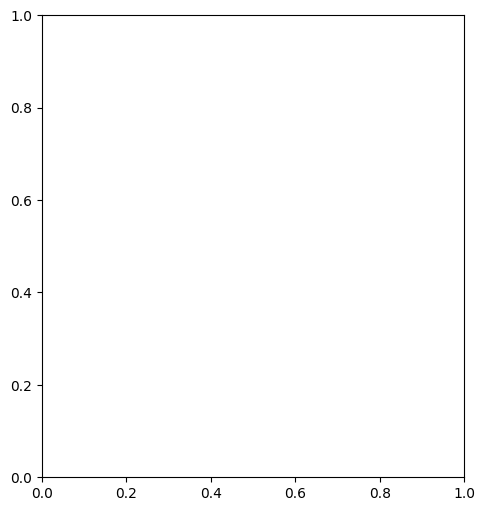

In [ ]:
# plot the output against the input signal, and the latent signals
# Plot input signal x against output signal y
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = cfg.time_range
K = cfg.embedding_channels
T = 500 # only show T steps

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, T+1), x_test_sample.flatten()[:T], label="Input Signal", color="blue")
plt.plot(np.arange(1, T+1), y.detach().flatten()[:T], label="Reconstructed Signal", color="green")
plt.xlabel("Steps")
plt.ylabel("Signal")
plt.title("Input vs Reconstructed Signal")
plt.legend()
plt.grid()

# Plot each of the k signals in a different color
plt.subplot(1, 2, 2)
for i in range(K):
    plt.plot(range(T), signal[0, i, :T].detach(), label=f"Signal {i+1}")
plt.xlabel("Time/Index")
plt.ylabel("Amplitude")
plt.title(f"{K} Latent Signals")
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()